In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

import re
import nltk #Natural Language Toolkit
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from joblib import dump, load

In [99]:
train_data_df         = pd.read_csv('/content/tmdb_5000_movies.csv')
# test_data_df          = pd.read_csv('/content/test_data.txt', sep=" ::: ", engine='python'
#   , header=None, names=["ID", "Title", "Description"])
# test_data_solution_df = pd.read_csv('/content/test_data_solution.txt', sep=" ::: ", engine='python'
#   , header=None, names=["ID", "Genre", "Description"])

def Explore(title_, dataframe_):
    display(Markdown(title_))
    display(Markdown('---'))
    display(dataframe_.tail())
    display('Descriptive Statistics')
    display(dataframe_.describe())
    display('Missing Values')
    display(dataframe_.isnull().sum().sort_values(ascending=False))
    display('Column Data Types')
    display(dataframe_.dtypes)

Explore('### Train Data', train_data_df)
# Explore('### Test Data', test_data_df)
# Explore('### Test Data Solutions', test_data_solution_df)

### Train Data

---

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-10-13,0,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,"Signed, Sealed, Delivered",7.0,6
4801,0,[],http://shanghaicalling.com/,126186,[],en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-05-03,0,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7
4802,0,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,25975,"[{""id"": 1523, ""name"": ""obsession""}, {""id"": 224...",en,My Date with Drew,Ever since the second grade when he first saw ...,1.929883,"[{""name"": ""rusty bear entertainment"", ""id"": 87...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2005-08-05,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,My Date with Drew,6.3,16


'Descriptive Statistics'

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


'Missing Values'

,0
homepage,3091
tagline,844
overview,3
runtime,2
release_date,1
id,0
budget,0
genres,0
original_title,0
popularity,0


'Column Data Types'

,0
budget,int64
genres,object
homepage,object
id,int64
keywords,object
original_language,object
original_title,object
overview,object
popularity,float64
production_companies,object


---
# Data Preprocessing

In [4]:
train_data_df = train_data_df.dropna(subset=['overview'])
train_data_df['overview'] = train_data_df['overview'].astype(str)
train_data_df['overview'].isnull().sum()

np.int64(0)

In [5]:
# Convert training data samples to lowercase.
# 'apply' applies the function to each column rather than individual cells.
train_data_df['overview'] = train_data_df['overview'].apply(lambda x: x.lower() if isinstance(x, str) else x)


# Remove character that aren't letter a-zA-Z, white spaces in the case of genre and description and for title we also preserve numbers to account for release dates which could be valuable information.
# 'map' applies the function to individual cells.
train_data_df['overview'] = train_data_df['overview'].map(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
# train_data_df[['Title']] = train_data_df[['Title']].map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
train_data_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,in the nd century a paraplegic marine is dispa...,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,captain barbossa long believed to be dead has ...,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,a cryptic message from bonds past sends him on...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,following the death of district attorney harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,john carter is a warweary former military capt...,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [6]:
# Download stopwords onto ram
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

train_data_df['overview'] = train_data_df['overview'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
train_data_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,nd century paraplegic marine dispatched moon p...,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,captain barbossa long believed dead come back ...,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,cryptic message bonds past sends trail uncover...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,following death district attorney harvey dent ...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,john carter warweary former military captain w...,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


---
### Vectorizer

$$
TF(w) = \frac{\text{Number of times w appears in d}}{\text{Total number of words in d}}
$$
where :
- w is word
- d is document(sample)
$$
IDF(w) = \log({\frac{N}{\text{DF}(w)}+1})
$$
where :
- N = Total number of documents(samples)
- DF(w) = Number of documents that contain w
- Adding 1 in the denominator prevents division by zero

$$
TFIDF(w,d) = TF(w,d) * (\text{IDF}(w))
$$

- Implementation of the above formulas can differ based on how the TfidfVectorizer is intialized accounting for smoothing, normalization etc.

In [7]:
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(train_data_df['overview'])

In [8]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the matrix to a readable format
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(feature_names)

['aa' 'aaa' 'aames' ... 'zula' 'zuzu' 'zyklon']


In [9]:
tfidf_matrix.shape

(4800, 23003)

---
# Machine Learning
## Clustering using KMeans (Unsupervised Learning)
- To calculate intra-cluster distance I'll be using interia which essentially calculates the square sum of the distance between each point in a cluster and the centroid of the cluster
$$
\text{inertia} = \sum_{i=1}^{K}\sum_{xj \in C_i} \left\| x_j - \mu_i \right\|^2
$$
Where
  - $K$ is Number of clusters
  - $C_i$ is cluster $i$
  - $x_j$ is data point assigned to cluster $i$
  - $\mu_i$ is the centroid of cluster i
  - $\left\| x_j - \mu_i \right\|^2$ is squared Euclidean distance between point and cluster center
- To calculate how well a data point fits to its cluster I'll use the silhouettte score which measures the relationship between a data point in cluster $C_i$ to every other cluster
### Average intra-cluster distance
$$
\text{a(c)} = \frac{1}{\left\|C_i \right\| - 1}\sum_{y \in C_i, y \neg x} \left\| x - y\right\|
$$
  - $C_i$ is the cluster containing the point x
  - $\left|C_i \right|$ is the number of points in clister i
  - $\left\| x - y \right\|$ is the distance between points x and another point y in the same clsuter
  - The sum iterates over all points in $C_i$, excluding $x$ itself.
  - The fraction normalizes the sum by the number of points in the cluster (excluding $x$).
### Average inter-cluster distnace
$$
\text{b(x)} = \min_{J \neg i}\frac{1}{\left| C_j \right|}\sum_{y \in C_j}\left\| x - y \right\|
$$  
  - The minimum is taken over all clusters $C_j$ where $j \neg i$
  - $\left|C_j \right|$ is the number of points in clister j  
  - The sum iterates over all points in cluster $C_j$, computing the average distance to $x$
  - The cluster $C_j$ that gives the minimum value is considered the "nearest" cluster.
### Silhouette score for x
$$
\text{s(x)} = \frac{\text{b(x) - a(x)}}{\max{\text{(a(x),b(x))}}}
$$
This measures how well $x$ is clustered:
Where
- If $s(x)$ is close to 1, the point is well clustered.
- If $s(x)$ is close to 0, the point is on the boundary between two clusters.
- If $s(x)$ is negative, the point is likely misclassified.


In [10]:
# Intialize a list for inertia
# k_cluster_inertia = []

# # Loop through 50 clusters
# for i in range(1,51):
#     kmeans_range     = KMeans(n_clusters=i, random_state=42)
#     kmeans_range.fit(tfidf_matrix)
#     k_cluster_inertia.append(kmeans_range.inertia_)

In [11]:
# # Store Interia values using joblib to compare later with lower dimension data
# dump(k_cluster_inertia, 'K-cluster-ineria-high-dimensionality')

In [12]:
# # Trained in google colab
# k_cluster_inertia = load('K-cluster-ineria-high-dimensionality-gc')

In [13]:
# high_dimensional_kmeans = pd.DataFrame({'Clsuters' : range(1,51), 'Inertia' : k_cluster_inertia})

# plt.figure(figsize=(12,5))
# plt.scatter(x=high_dimensional_kmeans['Clsuters'], y=high_dimensional_kmeans['Inertia'])
# plt.plot(high_dimensional_kmeans['Clsuters'], high_dimensional_kmeans['Inertia'], marker='o')
# plt.xlabel('Clusters')
# plt.ylabel('Inertia')
# plt.show


In [14]:
# Calculating silhouette score
# silhouette_score_high_dimensionality = silhouette_score(tfidf_matrix, KMeans(n_clusters=5, random_state=42).fit_predict(tfidf_matrix))
# print(silhouette_score_high_dimensionality)

---
# Principal Component Analysis

In [15]:
# Step 1: Fit PCA to find the optimal number of components
pca = PCA(n_components=2)  # Retain 2 components
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

In [16]:
# Step 2: Check how many components were selected
print(f"Number of components selected: {tfidf_pca.shape}")

Number of components selected: (4800, 2)


In [17]:
dump(tfidf_pca, 'tfidf_pca_2')

['tfidf_pca_2']

In [18]:
# # Intialize a list for inertia
# k_cluster_inertia_low_dimensionality = []

# # # Loop through 50 clusters
# for i in range(1,51):
#     kmeans_range     = KMeans(n_clusters=i, random_state=42)
#     kmeans_range.fit(tfidf_pca)
#     k_cluster_inertia_low_dimensionality.append(kmeans_range.inertia_)

In [19]:
# # Store Interia values using joblib to compare later with lower dimension data
# dump(k_cluster_inertia_low_dimensionality, 'K-cluster-ineria-low-dimensionality')
# print(k_cluster_inertia_low_dimensionality)

In [20]:
# low_dimensional_kmeans = pd.DataFrame({'Clsuters' : range(1,51), 'Inertia' : k_cluster_inertia_low_dimensionality})

# plt.figure(figsize=(12,5))
# plt.scatter(x=low_dimensional_kmeans['Clsuters'], y=low_dimensional_kmeans['Inertia'])
# plt.plot(low_dimensional_kmeans['Clsuters'], low_dimensional_kmeans['Inertia'], marker='o')
# plt.xlabel('Clusters')
# plt.ylabel('Inertia')
# plt.show


In [21]:
# Calculating silhouette score
# silhouette_score_low_dimensionality = silhouette_score(tfidf_pca, KMeans(n_clusters=5, random_state=42).fit_predict(tfidf_pca))
# print(silhouette_score_low_dimensionality)

---
# Gaussian Mixture Models

In [22]:
gmm = GaussianMixture(n_components=10, random_state=42)
gmm_pca = gmm.fit(tfidf_pca)

In [23]:
dump(gmm_pca, 'gmm_pca')

['gmm_pca']

In [24]:
gmm_pca_labels = gmm_pca.predict(tfidf_pca)

In [25]:
dump(gmm_pca_labels, 'gmm_pca_labels')

['gmm_pca_labels']

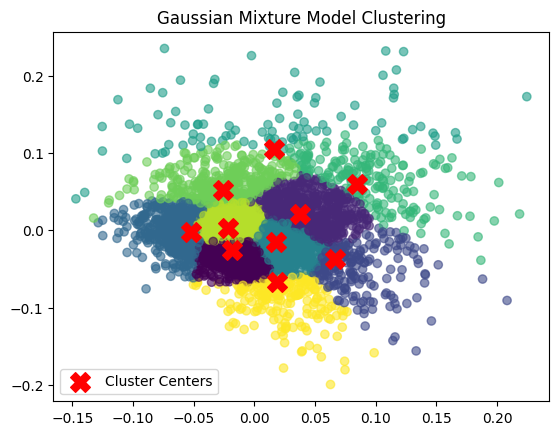

In [26]:
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=gmm_pca_labels, cmap='viridis', alpha=0.6)
plt.scatter(gmm_pca.means_[:, 0], gmm_pca.means_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title("Gaussian Mixture Model Clustering")
plt.legend()
plt.show()


In [27]:
probs = gmm_pca.predict_proba(tfidf_pca)
# print(probs[:10])  # Show probabilities for the first 10 samples


In [28]:
score = silhouette_score(tfidf_pca, gmm_pca_labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.28922369615821


---
# Heirarchical Clustering

In [91]:
hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
hc_labels = hc.fit_predict(tfidf_pca)

In [92]:
hc_score = silhouette_score(tfidf_pca, hc_labels)
print(f"Silhouette Score: {hc_score}")

Silhouette Score: 0.24900953717298818


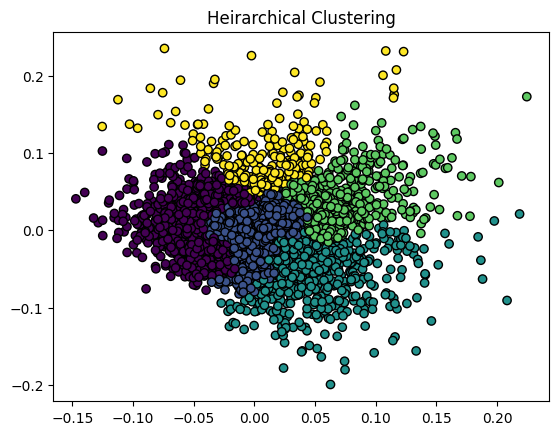

In [93]:
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=hc_labels, cmap='viridis', edgecolor='k')
plt.title("Heirarchical Clustering")
plt.show()

---
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN groups points into clusters based on density, defining dense regions as clusters and marking sparse regions as noise.

1. Key Parameters
  - $\epsilon$(eps)-> Defines the neighborhood radius around a point.
  - $\textit{MinPts}$ -> Minimum number of points required to form a dense region.
2. Core Concepts
  - Reachilibilty and Neighborhood <br>
  For a point $p$, define its $ϵ$-neighbourhood as:
  $$
  N_ϵ(P) = \{q \in D \mid d(p,q) \leq \varepsilon \}
  $$
  - Point Classification <br>
  Each point in the dataset is classified as:
    1. Core point: If $\mid N_ɛ(P) \mid \geq \textit{MinPts}$, meaning the point has enough neighbors.
    2. Border Point: Lies within $ϵ$-distance of a core point but has fewer than $\textit{MinPts} neighbors$
    3. Noise (Outlier) Point: Neither a core nor a border point.
3. Density Reachability.
  - A point $q$ is directly density-reachable from p if: <br>
  $q \in N_ϵ(P)$ and $\mid N_ϵ(P) \mid \geq \textit{MinPts}$ <br>
  Meaning a point $q$ is within the radius of the core, $p$ defined by radius $ϵ$ and the core encompases enough points to be considered a core.
  - A point $q$ is density-reachable from $p$ if there exist a chain of core points $P1, P2, ..., Pn$ <br>
  Meaning that a point $q$ is within a chain of clusters linked via making more cores that connect more points this is done to create dense areas that aren't sperical in nature essentially uncovering unique points and identfying outliers.
4. Density Connectivity.
- Two points $p$ and $q$ are density-connected if there exists a third point $o$ (a core point) such that both $p$ and $q$ are density-reachable from $o$.
- Ensures clusters remain globally connected, even if some points are not directly linked but are part of the same dense region.

    



In [65]:
dbscan = DBSCAN(eps=0.06, min_samples=3)  # Set parameters
dbscan_labels = dbscan.fit_predict(tfidf_pca)  # Fit model and get cluster labels

In [66]:
print(np.unique(dbscan_labels))

[-1  0]


In [67]:
dbscan_score = silhouette_score(tfidf_pca, dbscan_labels)
print(f"Silhouette Score: {dbscan_score}")

Silhouette Score: 0.7138141021587656


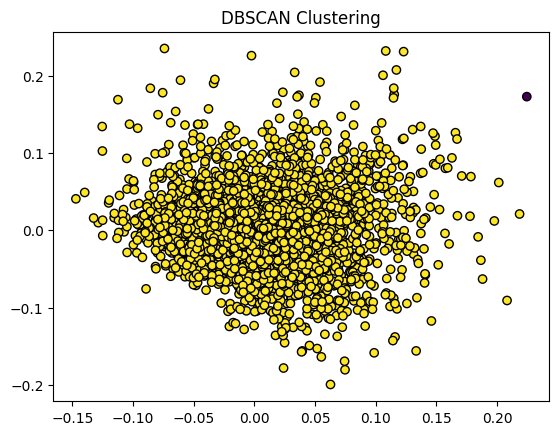

In [68]:
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=dbscan_labels, cmap='viridis', edgecolor='k')
plt.title("DBSCAN Clustering")
plt.show()

---
# Movie Recommendations

In [94]:
# Select a movie index (you can change this)
movie_idx = 100

# Get the cluster assignment for this movie
movie_cluster = hc_labels[movie_idx]
print(movie_cluster)

4


In [95]:
# Find all movies in the same cluster
similar_movies_idx = np.where(hc_labels == movie_cluster)[0]

In [96]:
# Exclude the selected movie itself
similar_movies_idx = similar_movies_idx[similar_movies_idx != movie_idx]

# Show top 5 recommendations
recommended_movies = train_data_df.iloc[similar_movies_idx].head(5)

In [97]:
print("Selected Movie:", train_data_df.iloc[movie_idx]['original_title'])  # Show selected movie
print("\nRecommended Movies:")
print(recommended_movies[['original_title', 'overview']])  # Show recommended movies

Selected Movie: the curious case of benjamin button

Recommended Movies:
                                       original_title                                           overview
14                                       man of steel  young boy learns extraordinary powers earth yo...
47                            star trek into darkness  crew enterprise called back home find unstoppa...
48                              jack the giant slayer  story ancient war reignited young farmhand unw...
53  indiana jones and the kingdom of the crystal s...  set cold war soviets led swordwielding irina s...
61                                  jupiter ascending  universe human genetic material precious commo...


In [101]:
def recommend_movies_by_title(movie_title, df, labels):
    # Ensure titles are in lowercase for case-insensitive matching
    df['original_title'] = df['original_title'].str.strip().str.lower()
    movie_title = movie_title.strip().lower()

    # Find all matching titles
    movie_idx = df[df['original_title'].str.contains(movie_title, regex=False)].index.tolist()

    if not movie_idx:
        return f"Movie '{movie_title}' not found in the dataset."

    movie_idx = movie_idx[0]  # Pick the first match if multiple

    # Find the cluster for this movie
    movie_cluster = labels[movie_idx]

    # Find all movies in the same cluster
    similar_movies_idx = np.where(labels == movie_cluster)[0]

    # Exclude the selected movie itself
    similar_movies_idx = similar_movies_idx[similar_movies_idx != movie_idx]

    # Get the recommended movies
    recommended_movies = df.iloc[similar_movies_idx].head(5)

    print(f"Selected Movie: {df.iloc[movie_idx]['original_title']}")
    print("\nRecommended Movies:")
    print(recommended_movies[['original_title', 'overview']])

# Example Usage
movie_name = "Newlyweds"  # Change this to any movie title
recommend_movies_by_title(movie_name, train_data_df, hc_labels)



Selected Movie: newlyweds

Recommended Movies:
               original_title                                           overview
38   the amazing spider-man 2  For Peter Parker, life is busy. Between taking...
77                 inside out  Growing up can be a bumpy road, and it's no ex...
119             batman begins  Driven by tragedy, billionaire Bruce Wayne ded...
130                      bolt  Bolt is the star of the biggest show in Hollyw...
136                 bee movie  Barry B. Benson, a bee who has just graduated ...
